In [1]:
# Install Deepwave
!pip install deepwave==0.0.9

In [2]:
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import deepwave

In [3]:
# Set parameters
freq = 6.0
dx = 25.0
dt = 0.004 # 4ms
nz = 100
nx = 401
nt = int(3 / dt) # 2s
num_dims = 2
num_shots = 80
num_sources_per_shot = 1
num_receivers_per_shot = nx
source_spacing = 125
receiver_spacing = dx
device = torch.device('cuda:0')

# Create arrays containing the source and receiver locations
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = (1.0+torch.arange(num_shots)).float() * source_spacing
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Load ricker wavelet, frequencies below 3 Hz are muted
src_bp = scipy.io.loadmat('src_bp.mat')
src_bp = src_bp['src_bp']
wavelet = torch.tensor(src_bp,requires_grad=False)
source_amplitudes_true = (wavelet.reshape(-1, 1, 1).repeat(1, num_shots, num_sources_per_shot))

In [4]:
##data envelope calculation
def hilbert_transform(data_in, p):
  nt, ns, nr = data_in.shape
  transforms = torch.fft.fftn(data_in,dim=0)
  #print(transforms.shape)
  transforms[1:nt//2,:,:]      *= 2.0
  transforms[nt//2 + 1: nt,:,:]  = 0+0j
  transforms[0,:,:] = 0;
  data_out = torch.abs(torch.fft.ifftn(transforms,dim=0))**p

  return data_out

torch.Size([750, 1, 1])


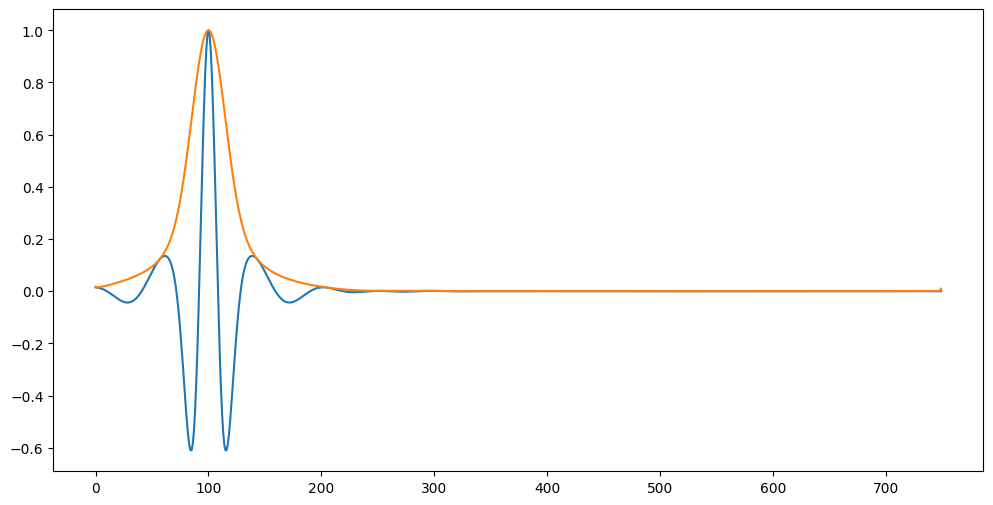

In [5]:
wavelet = torch.tensor(src_bp).reshape(-1, 1, 1)
print(wavelet.shape)
trace = wavelet.cpu().numpy()
trace_h = hilbert_transform(wavelet,1).cpu().numpy()
#trace_h2 = trace_h*trace_h
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(trace[0:1000,0,0])
plt.plot(trace_h[0:1000,0,0])
#plt.plot(trace_h2[0:1000,0,0])
plt.savefig('wavelet.jpeg', dpi=400)

In [6]:
# load true model
v = scipy.io.loadmat('over_v_full.mat')
model_true = v['v']
model_true = torch.Tensor(model_true) # Convert to a PyTorch Tensor
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_true = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

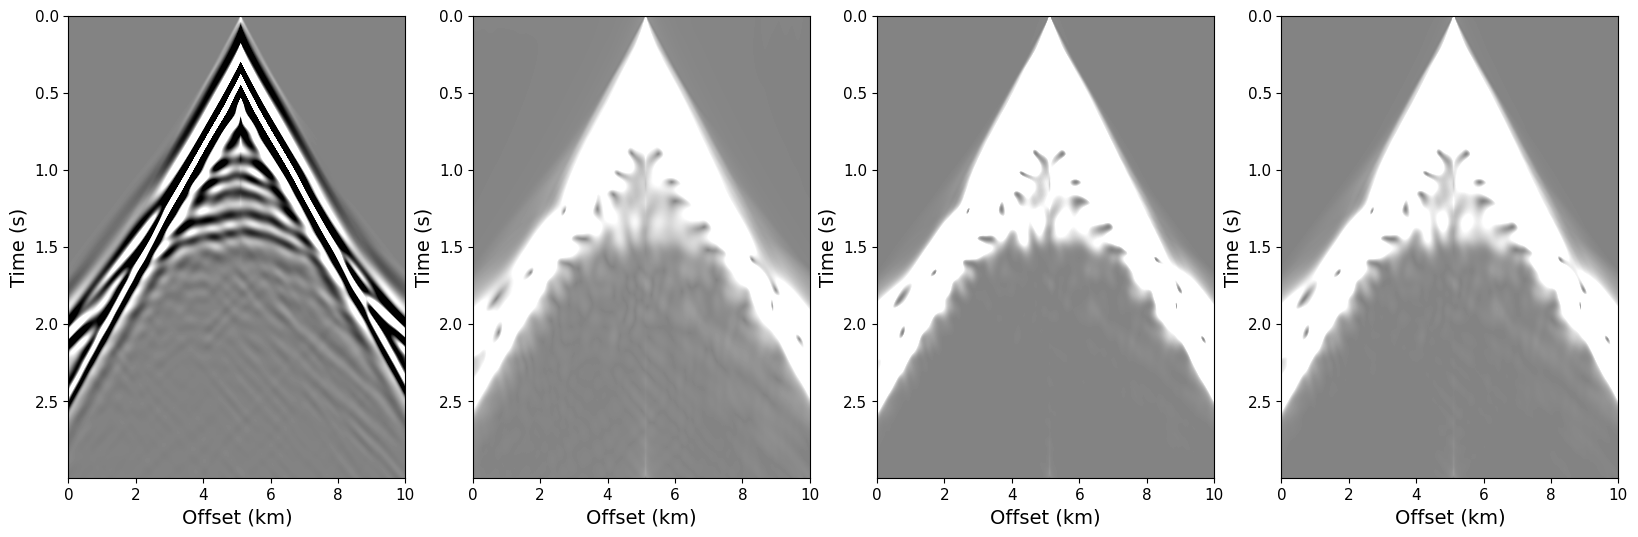

In [7]:
vmin, vmax = np.percentile(receiver_amplitudes_true[:,1].cpu().numpy(), [4,96])
receiver_amplitudes_true_envelop = hilbert_transform(receiver_amplitudes_true,1)
receiver_amplitudes_true_envelop2 = hilbert_transform(receiver_amplitudes_true,2)
receiver_amplitudes_true_envelop15 = hilbert_transform(receiver_amplitudes_true,1.5)
## plot data
plt.style.use('default')
plt.figure(figsize=(20,6))
plt.subplot(1,4,1)
ax = plt.gca()
im = ax.imshow(receiver_amplitudes_true[:,40].cpu().numpy(),extent=[0,(nx-1)*dx/1000,(nt-1)*dt,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="gray")
plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=11)
plt.ylabel('Time (s)', fontsize=14)
plt.yticks(fontsize=11)
plt.subplot(1,4,2)
ax = plt.gca()
im = ax.imshow(receiver_amplitudes_true_envelop[:,40].cpu().numpy(),extent=[0,(nx-1)*dx/1000,(nt-1)*dt,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="gray")
plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=11)
plt.ylabel('Time (s)', fontsize=14)
plt.yticks(fontsize=11)
plt.subplot(1,4,3)
ax = plt.gca()
im = ax.imshow(receiver_amplitudes_true_envelop2[:,40].cpu().numpy(),extent=[0,(nx-1)*dx/1000,(nt-1)*dt,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="gray")
plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=11)
plt.ylabel('Time (s)', fontsize=14)
plt.yticks(fontsize=11)
plt.subplot(1,4,4)
ax = plt.gca()
im = ax.imshow(receiver_amplitudes_true_envelop15[:,40].cpu().numpy(),extent=[0,(nx-1)*dx/1000,(nt-1)*dt,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="gray")
plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=11)
plt.ylabel('Time (s)', fontsize=14)
plt.yticks(fontsize=11)
plt.savefig('data.jpeg', dpi=400)


In [8]:
# Create initial guess model for inversion by smoothing the true model
model_init = scipy.ndimage.gaussian_filter(model_true.cpu().detach().numpy(),sigma=20)
model_init = torch.tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True
# Create initial guess source amplitude for inversion
source_amplitudes = torch.tensor(src_bp).reshape(-1, 1, 1).to(device)

# Set-up inversion

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': [model], 'lr': 20, 'weight_decay':0e-11}]) # 30


Epoch: 0 Loss:  -7.34968775510788 model_loss:  177063.9
Epoch: 1 Loss:  -7.4777936935424805 model_loss:  176377.83
Epoch: 2 Loss:  -7.532170593738556 model_loss:  171622.33
Epoch: 3 Loss:  -7.588461637496948 model_loss:  165158.89
Epoch: 4 Loss:  -7.659544587135315 model_loss:  158626.81
Epoch: 5 Loss:  -7.7387179136276245 model_loss:  152981.44
Epoch: 6 Loss:  -7.812565624713898 model_loss:  148390.61
Epoch: 7 Loss:  -7.865158557891846 model_loss:  144684.03
Epoch: 8 Loss:  -7.907709956169128 model_loss:  141713.55
Epoch: 9 Loss:  -7.944529831409454 model_loss:  139266.52
Epoch: 10 Loss:  -7.96641343832016 model_loss:  137119.88


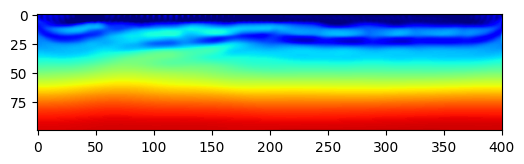

Epoch: 11 Loss:  -7.973635196685791 model_loss:  135064.48
Epoch: 12 Loss:  -7.978456139564514 model_loss:  133098.58
Epoch: 13 Loss:  -7.9823344349861145 model_loss:  131328.61
Epoch: 14 Loss:  -7.984900116920471 model_loss:  129752.164
Epoch: 15 Loss:  -7.986860036849976 model_loss:  128329.95
Epoch: 16 Loss:  -7.988216042518616 model_loss:  127022.91
Epoch: 17 Loss:  -7.989294052124023 model_loss:  125807.25
Epoch: 18 Loss:  -7.990140020847321 model_loss:  124663.81
Epoch: 19 Loss:  -7.990814745426178 model_loss:  123571.914
Epoch: 20 Loss:  -7.9913307428359985 model_loss:  122512.05


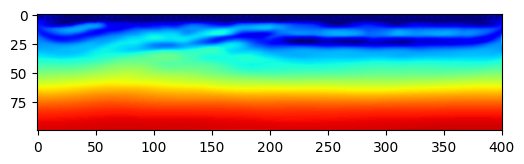

Epoch: 21 Loss:  -7.991725921630859 model_loss:  121469.125
Epoch: 22 Loss:  -7.992030024528503 model_loss:  120432.625
Epoch: 23 Loss:  -7.992272257804871 model_loss:  119395.375
Epoch: 24 Loss:  -7.992474675178528 model_loss:  118353.766
Epoch: 25 Loss:  -7.992651402950287 model_loss:  117306.92
Epoch: 26 Loss:  -7.99280858039856 model_loss:  116255.0
Epoch: 27 Loss:  -7.992947697639465 model_loss:  115198.39
Epoch: 28 Loss:  -7.993070006370544 model_loss:  114137.27
Epoch: 29 Loss:  -7.993174135684967 model_loss:  113071.38
Epoch: 30 Loss:  -7.993260741233826 model_loss:  112000.08


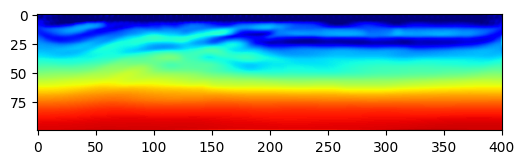

Epoch: 31 Loss:  -7.993330657482147 model_loss:  110922.54
Epoch: 32 Loss:  -7.993385076522827 model_loss:  109837.945
Epoch: 33 Loss:  -7.993425726890564 model_loss:  108745.67
Epoch: 34 Loss:  -7.993454396724701 model_loss:  107645.23
Epoch: 35 Loss:  -7.993472516536713 model_loss:  106536.38
Epoch: 36 Loss:  -7.993481993675232 model_loss:  105419.05
Epoch: 37 Loss:  -7.993485450744629 model_loss:  104293.2
Epoch: 38 Loss:  -7.993484139442444 model_loss:  103159.016
Epoch: 39 Loss:  -7.993480384349823 model_loss:  102016.83
Epoch: 40 Loss:  -7.993475019931793 model_loss:  100867.13


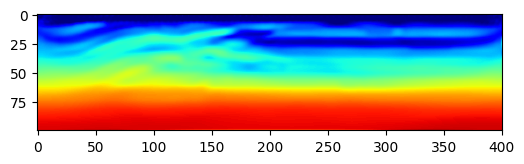

Epoch: 41 Loss:  -7.993470132350922 model_loss:  99710.7
Epoch: 42 Loss:  -7.9934680461883545 model_loss:  98548.58
Epoch: 43 Loss:  -7.993469655513763 model_loss:  97381.99
Epoch: 44 Loss:  -7.9934762716293335 model_loss:  96212.445
Epoch: 45 Loss:  -7.993490159511566 model_loss:  95041.57
Epoch: 46 Loss:  -7.993510842323303 model_loss:  93871.23
Epoch: 47 Loss:  -7.993540823459625 model_loss:  92703.375
Epoch: 48 Loss:  -7.993580222129822 model_loss:  91540.086
Epoch: 49 Loss:  -7.993629157543182 model_loss:  90383.484
Epoch: 50 Loss:  -7.993688642978668 model_loss:  89235.766


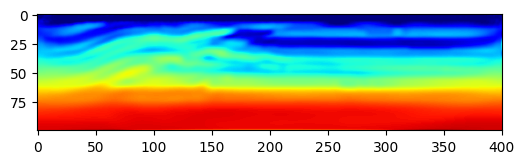

Epoch: 51 Loss:  -7.993758916854858 model_loss:  88099.11
Epoch: 52 Loss:  -7.993839800357819 model_loss:  86975.67
Epoch: 53 Loss:  -7.99392968416214 model_loss:  85867.52
Epoch: 54 Loss:  -7.994029104709625 model_loss:  84776.66
Epoch: 55 Loss:  -7.994136929512024 model_loss:  83704.89
Epoch: 56 Loss:  -7.994251072406769 model_loss:  82653.94
Epoch: 57 Loss:  -7.994372308254242 model_loss:  81625.25
Epoch: 58 Loss:  -7.994497776031494 model_loss:  80620.15
Epoch: 59 Loss:  -7.99462765455246 model_loss:  79639.73
Epoch: 60 Loss:  -7.994761168956757 model_loss:  78684.82


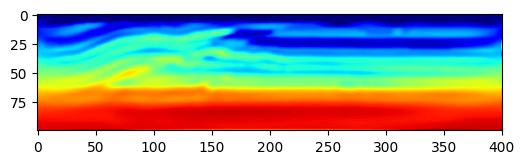

Epoch: 61 Loss:  -7.994896769523621 model_loss:  77756.14
Epoch: 62 Loss:  -7.995032906532288 model_loss:  76854.07
Epoch: 63 Loss:  -7.995169520378113 model_loss:  75978.875
Epoch: 64 Loss:  -7.995306134223938 model_loss:  75130.61
Epoch: 65 Loss:  -7.995442092418671 model_loss:  74309.15
Epoch: 66 Loss:  -7.995575428009033 model_loss:  73514.234
Epoch: 67 Loss:  -7.995707035064697 model_loss:  72745.45
Epoch: 68 Loss:  -7.99583512544632 model_loss:  72002.33
Epoch: 69 Loss:  -7.995960772037506 model_loss:  71284.23
Epoch: 70 Loss:  -7.996083617210388 model_loss:  70590.51


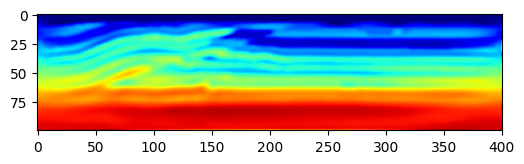

Epoch: 71 Loss:  -7.996201813220978 model_loss:  69920.44
Epoch: 72 Loss:  -7.996316313743591 model_loss:  69273.3
Epoch: 73 Loss:  -7.996427536010742 model_loss:  68648.24
Epoch: 74 Loss:  -7.996534645557404 model_loss:  68044.484
Epoch: 75 Loss:  -7.996638000011444 model_loss:  67461.234
Epoch: 76 Loss:  -7.996736526489258 model_loss:  66897.68
Epoch: 77 Loss:  -7.9968321323394775 model_loss:  66352.984
Epoch: 78 Loss:  -7.996924340724945 model_loss:  65826.28
Epoch: 79 Loss:  -7.997011184692383 model_loss:  65316.977
Epoch: 80 Loss:  -7.997093856334686 model_loss:  64824.34


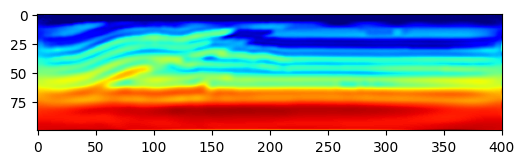

Epoch: 81 Loss:  -7.99717378616333 model_loss:  64347.26
Epoch: 82 Loss:  -7.997251629829407 model_loss:  63885.094
Epoch: 83 Loss:  -7.997324228286743 model_loss:  63437.746
Epoch: 84 Loss:  -7.997382283210754 model_loss:  63004.383
Epoch: 85 Loss:  -7.997441411018372 model_loss:  62583.574
Epoch: 86 Loss:  -7.997507035732269 model_loss:  62174.848
Epoch: 87 Loss:  -7.997545838356018 model_loss:  61778.984
Epoch: 88 Loss:  -7.997549653053284 model_loss:  61395.145
Epoch: 89 Loss:  -7.9975258111953735 model_loss:  61021.348
Epoch: 90 Loss:  -7.997519552707672 model_loss:  60657.5


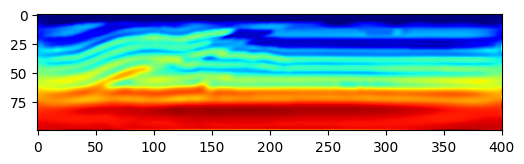

Epoch: 91 Loss:  -7.9972827434539795 model_loss:  60303.91
Epoch: 92 Loss:  -7.997023284435272 model_loss:  59964.953
Epoch: 93 Loss:  -7.996031403541565 model_loss:  59633.88
Epoch: 94 Loss:  -7.995184898376465 model_loss:  59319.875
Epoch: 95 Loss:  -7.991575717926025 model_loss:  59005.637
Epoch: 96 Loss:  -7.988210499286652 model_loss:  58730.258
Epoch: 97 Loss:  -7.978406131267548 model_loss:  58487.81
Epoch: 98 Loss:  -7.966717004776001 model_loss:  58214.438
Epoch: 99 Loss:  -7.949415028095245 model_loss:  57991.207
Epoch: 100 Loss:  -7.928134322166443 model_loss:  57720.3


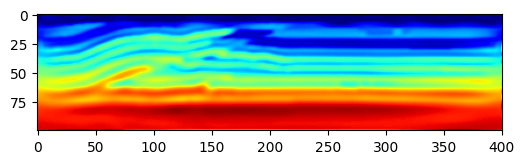

Epoch: 101 Loss:  -7.931233704090118 model_loss:  57368.484
Epoch: 102 Loss:  -7.961289405822754 model_loss:  57068.273
Epoch: 103 Loss:  -7.973844766616821 model_loss:  56758.32


In [ ]:
# Iterative inversion loop
t_start = time.time()
num_batches = 8 # split data into 8 batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
num_epochs = 150 # Pass through the entire dataset 30 times
vmin, vmax = np.percentile(model_true.numpy(), [2,98]) # For plotting
model_loss = []
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for it in range(num_batches):
    optimizer.zero_grad()
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
    batch_rcv_amps_true = receiver_amplitudes_true[:,it::num_batches].to(device)
    batch_rcv_amps_true_envelop = receiver_amplitudes_true_envelop[:,it::num_batches].to(device)
    batch_rcv_amps_true_envelop = hilbert_transform(batch_rcv_amps_true,1.5).to(device)

    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
    batch_rcv_amps_pred_envelop = hilbert_transform(batch_rcv_amps_pred,1.5).to(device)

    u_obs_envelop = batch_rcv_amps_true_envelop/torch.sqrt(torch.mul(batch_rcv_amps_true_envelop,batch_rcv_amps_true_envelop).sum())
    u_pred_envelop = batch_rcv_amps_pred_envelop/torch.sqrt(torch.mul(batch_rcv_amps_pred_envelop,batch_rcv_amps_pred_envelop).sum())

    u_obs = batch_rcv_amps_true/torch.sqrt(torch.mul(batch_rcv_amps_true,batch_rcv_amps_true).sum())
    u_pred = batch_rcv_amps_pred/torch.sqrt(torch.mul(batch_rcv_amps_pred,batch_rcv_amps_pred).sum())

    # l2 norm loss
    #loss = criterion(batch_rcv_amps_true,batch_rcv_amps_pred)
    # correlation loss
    #loss = torch.sum(-torch.mul(u_obs, u_pred))
    # envelop correlation loss
    #loss = torch.sum(-torch.mul(u_obs_envelop, u_pred_envelop))
    #sigmoid weighted correlation loss
    weight = 1.0/(1.0 + np.exp(-(epoch-num_epochs//3)/10.0))
    loss = (1.0 - weight)*torch.sum(-torch.mul(u_obs_envelop, u_pred_envelop)) + weight*torch.sum(-torch.mul(u_obs, u_pred))
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
  #scheduler.step()
  v_loss = criterion(model.cpu(),model_true.cpu()).detach().numpy()
  model_loss.append(v_loss.item())
  print('Epoch:', epoch, 'Loss: ', epoch_loss,'model_loss: ', v_loss)
  if epoch !=0 and epoch % 10 == 0:
    plt.figure(figsize=(6, 4))
    plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax,
               cmap='jet')
    plt.show()

t_end = time.time()
print('Runtime:', t_end - t_start)


In [ ]:
model_loss = np.array(model_loss)
scipy.io.savemat('model_loss_envelopcorrelation.mat',{'model_loss':model_loss/model_loss.max()})
plt.figure(figsize=(5,4))
plt.plot(range(1,num_epochs+1),model_loss/model_loss.max())
plt.xlabel("Epoch")
plt.ylabel("Model misfit")
plt.savefig('model_loss_envelopcorrelation.jpeg', dpi=400)

In [ ]:
# plot true velocity
plt.style.use('default')
plt.figure(figsize=(15, 5))
ax = plt.gca()
im = ax.imshow(model_init.numpy()/1000.0,extent=[0,(nx-1)*dx/1000,(nz-1)*dx/1000,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="jet")
plt.xlabel('Distance (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)
plt.savefig('ini_v.jpeg', dpi=400)
scipy.io.savemat('model_init.mat',{'model_init':model_init.numpy()})

# plot inverted velocity
plt.style.use('default')
plt.figure(figsize=(15, 5))
ax = plt.gca()
im = ax.imshow(model.cpu().detach().numpy()/1000.0,extent=[0,(nx-1)*dx/1000,(nz-1)*dx/1000,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="jet")
plt.xlabel('Distance (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)
plt.savefig('model_inv_envelopecorrelation15.jpeg', dpi=400)
scipy.io.savemat('model_inv_envelopecorrelation15.mat',{'model_inv_envelope15':model.cpu().detach().numpy()})

# plot true velocity
plt.style.use('default')
plt.figure(figsize=(15, 5))
ax = plt.gca()
im = ax.imshow(model_true.cpu().detach().numpy()/1000.0,extent=[0,(nx-1)*dx/1000,(nz-1)*dx/1000,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="jet")
plt.xlabel('Distance (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)
plt.savefig('true_v.jpeg', dpi=400)
scipy.io.savemat('model_true.mat',{'model_true':model_true.cpu().detach().numpy()})
